In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [60]:
def load_data(filename):
    df = pd.read_csv(filename)
    df['start_time'] = pd.to_datetime(df['start_time'])
    df.set_index('start_time', inplace=True)
    return df

train_df = load_data('data/no1_train.csv')
val_df = load_data('data/no1_validation.csv')

train_df.head()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
start_time,,,,,,,,,
2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


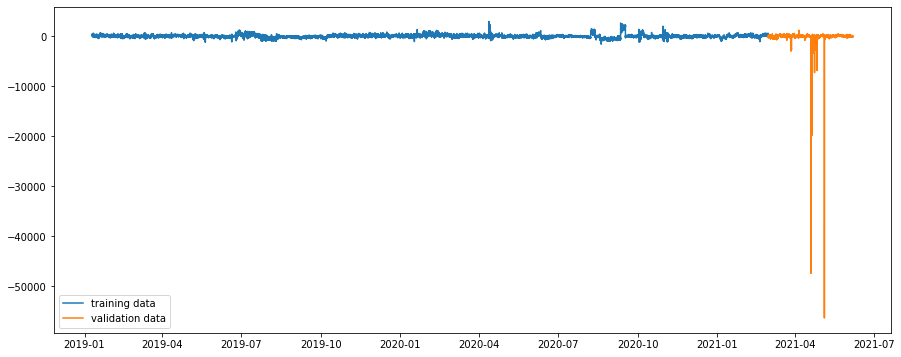

In [61]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(train_df['y'], label='training data')
plt.plot(val_df['y'], label='validation data')
plt.legend()

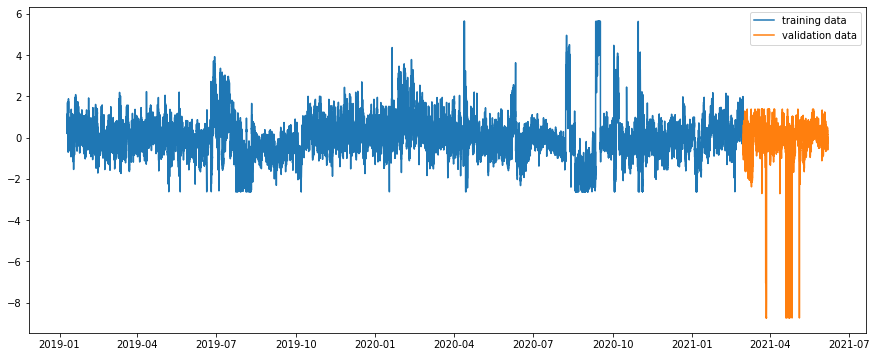

In [62]:
def preprocess(df):
    # Clip outliers
    df['y'] = df['y'].clip(upper=df['y'].quantile(0.995))
    df['y'] = df['y'].clip(lower=df['y'].quantile(0.005))
    # Normalize
    for col in df.columns:
        if df[col].std() != 0:
            df[col] = (df[col] - df[col].mean()) / df[col].std()

preprocess(train_df)
preprocess(val_df)

plt.plot(train_df['y'], label='training data')
plt.plot(val_df['y'], label='validation data')
plt.legend()

In [6]:
def add_features(df):
    # Date time features
    df['time_of_day'] = (df.index.minute + df.index.hour * 60) / (24 * 60)
    df['time_of_week'] = (df['time_of_day'] + df.index.dayofweek) / 7
    df['time_of_year'] = (df['time_of_day'] + df.index.dayofyear) / 365
    # Lag features
    df['previous_y'] = df['y'].shift(1)
    df['previous_day_y'] = df['y'].shift(12 * 24)
    df['previous_day_mean_y'] = df['y'].rolling(12 * 24).mean()

add_features(train_df)
add_features(val_df)

In [7]:
train_df.head()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,time_of_day,time_of_week,time_of_year,previous_y,previous_day_y,previous_day_mean_y
start_time,,,,,,,,,,,,,,,
2019-01-09 14:10:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.156813,0.417943,-1.843697,0.590278,0.370040,0.026275,NaN,NaN,NaN
2019-01-09 14:15:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.118388,0.417943,-1.843697,0.593750,0.370536,0.026284,1.156813,NaN,NaN
2019-01-09 14:20:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.097019,0.417943,-1.843697,0.597222,0.371032,0.026294,1.118388,NaN,NaN
2019-01-09 14:25:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.003012,0.417943,-1.843697,0.600694,0.371528,0.026303,1.097019,NaN,NaN
2019-01-09 14:30:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,0.909338,0.417943,-1.843697,0.604167,0.372024,0.026313,1.003012,NaN,NaN


In [8]:
sequence_length = 12 * 12 # 12 hours

def create_dataset(df):
    return tf.keras.utils.timeseries_dataset_from_array(
        data=df,
        targets=df.iloc[sequence_length:][['y']],
        sequence_length=sequence_length,
        start_index=12 * 24, # exclude first day
        end_index=df.shape[0] - sequence_length - 1, # exclude last index
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

train_dataset.element_spec

2022-05-04 02:22:52.566134: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(TensorSpec(shape=(None, None, 15), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))

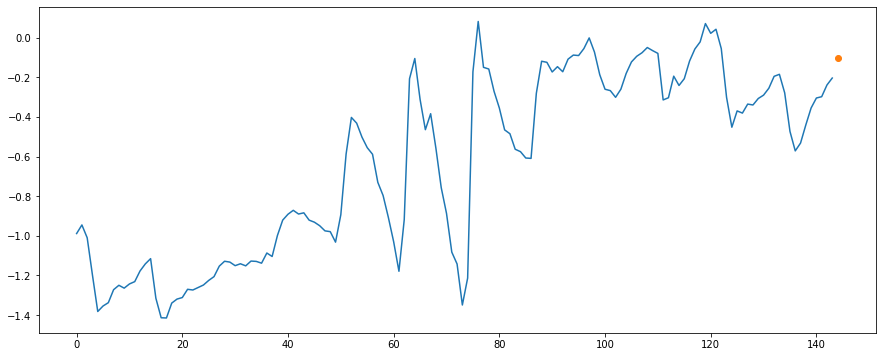

In [9]:
for x, y in train_dataset.take(1):
    plt.plot(x[0, :, 6])
    plt.plot(sequence_length, y[0], 'o')

In [10]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(sequence_length, train_df.shape[1])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(units=1)
])

lstm.compile(optimizer='adam', loss='mse')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6144      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='models/model_checkpoint.h5',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

try:
    lstm.load_weights('models/model.h5')
except FileNotFoundError:
    history = lstm.fit(
        train_dataset,
        epochs=1,
        validation_data=val_dataset,
        callbacks=[es_callback, checkpoint_callback],
    )
    lstm.save('models/model.h5')

In [248]:
def forecast(model, df, start_ind, seq_len, forecast_len):
    df_copy = df.copy()
    for i in range(start_ind, start_ind + forecast_len):
        model_input = df_copy[i:i + seq_len].values.reshape((1, seq_len, df_copy.shape[1]))
        forecast = model.predict(model_input)
        df_copy['y'][i + seq_len] = forecast # replace y with forecast
        df_copy['previous_y'][i + seq_len + 1] = forecast # replace previous_y with forecast
        df_copy['previous_day_mean_y'] = df_copy['y'].rolling(12 * 24).mean() # update mean y with forecast
    return df_copy['y'][start_ind + seq_len:start_ind + seq_len + forecast_len]

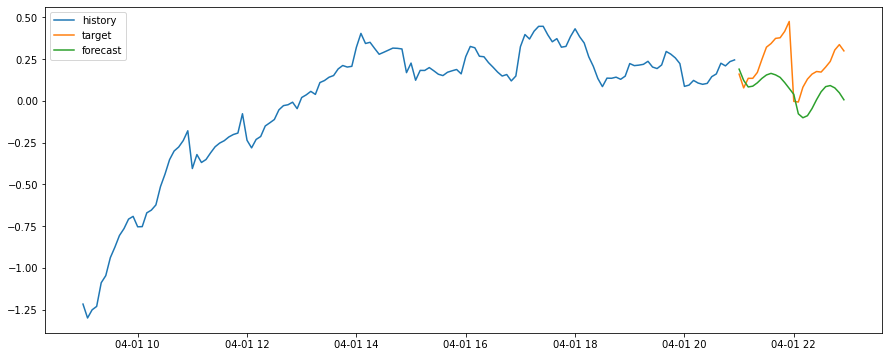

In [274]:
def plot_random_sample(df):
    hist_len = 12 * 12
    target_len = 12 * 2
    start_ind = np.random.randint(df.shape[0] - hist_len - target_len - 12 * 24) + 12 * 24
    hist = df.iloc[start_ind:start_ind + hist_len]
    target = df.iloc[start_ind + hist_len:start_ind + hist_len + target_len]
    plt.plot(hist['y'], label='history')
    plt.plot(target['y'], label='target')
    plt.plot(forecast(lstm, df, start_ind, hist_len, target_len), label='forecast')
    plt.legend()

plot_random_sample(val_df)

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()